In [1]:
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from utils_dataset.gan_dataset import GANDataset
from utils_train.model import weights_init
from utils_train.trainer import Trainer
from utils_train.log import plot_history, reconstruct_images

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


In [2]:
ROOT_FOLDER = './Flowers/17flowers/'
BATCH_SIZE = 8

dataset = GANDataset(ROOT_FOLDER)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

items = next(iter(dataloader))
print('x:', items[0].shape)
print('y:', items[1].shape)
print('from', items[0].min(), 'to', items[0].max())

x: torch.Size([8, 3, 32, 32])
y: torch.Size([8, 3, 128, 128])
from tensor(-1.) to tensor(1.)


In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def get_conv_sequence(in_ch, out_ch, f, s, p):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, f, s, p, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.2, inplace=True),
            )

        self.main = nn.Sequential(
            get_conv_sequence(3, 16, 3, s=2, p=1), # /2
            get_conv_sequence(16, 32, 3, s=1, p=1), # /2
            get_conv_sequence(32, 32, 3, s=1, p=1), # /2
            get_conv_sequence(32, 64, 3, s=1, p=1), # /2
            nn.Conv2d(64, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def get_conv_sequence(in_ch, out_ch, f, s, p):
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, f, s, p, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(True),
            )

        self.main = nn.Sequential(
            get_conv_sequence(3, 16, 3, s=1, p=1),
            get_conv_sequence(16, 32, 4, s=2, p=1), # x2
            get_conv_sequence(32, 64, 3, s=1, p=1),
            get_conv_sequence(64, 128, 4, s=2, p=1), # x4
            nn.ConvTranspose2d(128, 3, 3, 1, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

netG = Generator().to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

optimizerD = torch.optim.Adam(netD.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))

trainer = Trainer(netG, netD, optimizerG, optimizerD, device)

Epoch 1/30
[170/170] - 15s 91ms/step - d_loss: 0.000797 - loss: 0.0414 - img_loss: 0.04138 - g_loss: 0.00076876
Epoch 2/30
[170/170] - 15s 90ms/step - d_loss: 0.0002723 - loss: 0.03687 - img_loss: 0.03687 - g_loss: 0.0002658
Epoch 3/30
[170/170] - 15s 90ms/step - d_loss: 0.0001286 - loss: 0.0335 - img_loss: 0.0335 - g_loss: 0.000123411
Epoch 4/30
[170/170] - 15s 90ms/step - d_loss: 8.59e-05 - loss: 0.03458 - img_loss: 0.03458 - g_loss: 8.184e-05057
Epoch 5/30
[170/170] - 15s 90ms/step - d_loss: 6.235e-05 - loss: 0.0455 - img_loss: 0.0455 - g_loss: 5.823e-0555
Epoch 6/30
[170/170] - 15s 90ms/step - d_loss: 4.08e-05 - loss: 0.04178 - img_loss: 0.04175 - g_loss: 3.92e-0555
Epoch 7/30
[170/170] - 15s 90ms/step - d_loss: 3.17e-05 - loss: 0.03038 - img_loss: 0.03038 - g_loss: 3.05e-0555
Epoch 8/30
[170/170] - 15s 90ms/step - d_loss: 2.82e-05 - loss: 0.0444 - img_loss: 0.0444 - g_loss: 2.75e-050555
Epoch 9/30
[170/170] - 15s 90ms/step - d_loss: 1.91e-05 - loss: 0.03427 - img_loss: 0.03427 - g

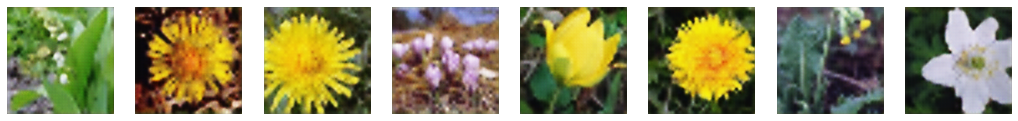

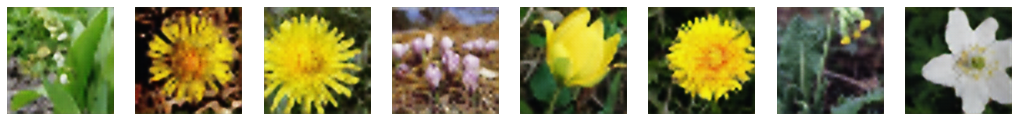

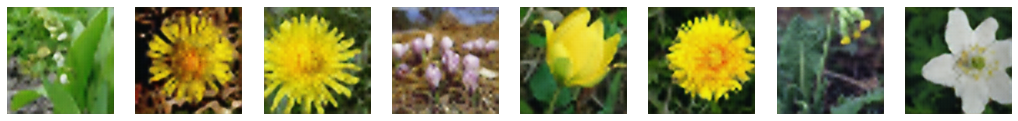

In [6]:
SAVE_PATH = './weights/'
history = trainer.train(dataloader, 30, SAVE_PATH, '17flowers', 10)

In [7]:
torch.cuda.empty_cache()

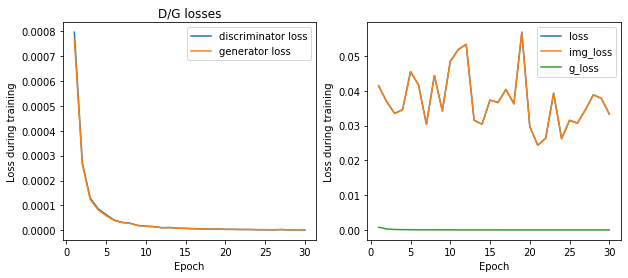

In [8]:
plot_history(history, ['loss', 'img_loss', 'g_loss'])

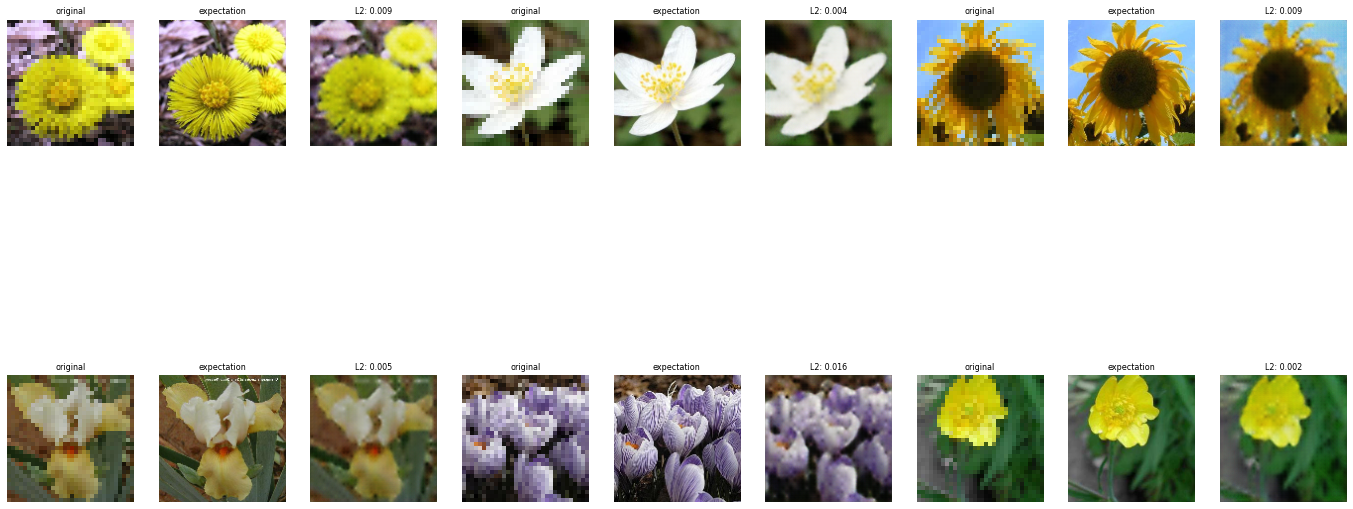

In [10]:
reconstruct_images(netG, items[0].to(device), items[1].to(device), 2, 3, size=3, random=True)
